# A mobile game A/B testing

## 1. Description
  We've got a dataset of A/B test results from [Cookie Cats](https://apps.apple.com/us/app/cookie-cats/id1078297893) mobile game by [Tactile Games](https://tactilegames.com).  
  
  The **goal** of that A/B test was to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either ***gate30*** or ***gate40***.  
  
  (*Game process:* As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.)

## 2. Dataset
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

* ***userid***: A unique number that identifies each player.
* ***version***: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
* ***sumgamerounds***: the number of game rounds played by the player during the first 14 days after install.
* ***retention_1***: Did the player come back and play 1 day after installing?
* ***retention_7***: Did the player come back and play 7 days after installing?

In [13]:
# Importing all the needed packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Uploading the dataset
df = pd.read_csv('D:\BSNS\STUDY\Python\A_B_Testing\cookie_cats\cookie_cats.csv')

In [4]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


## 3. Goal
I'd like to check if changing the start gate of the game has a statistically significant effect on: 
1. player's ***total game rounds***.
2. player's ***retention***.

And was this a effect positive or not.

## 4. EDA

In [4]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Data cleaning

#### Do we have any nulls?

In [5]:
# Do we have any nulls?
df.isnull().any()
# No. That's a nice, comfortable, cleaned Kaggle's dataset.

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

#### Do we have any outliers?

In [6]:
# Do we have any outliers? (We have only 1 quantitative column - sum_gamerounds - so, let's check it)
df[['userid', 'sum_gamerounds']].sort_values('sum_gamerounds', ascending=False)

,userid,sum_gamerounds
57702,6390605,49854
7912,871500,2961
29417,3271615,2640
43671,4832608,2438
48188,5346171,2294
...,...,...
59687,6610805,0
23707,2639282,0
59670,6608718,0
59645,6604544,0


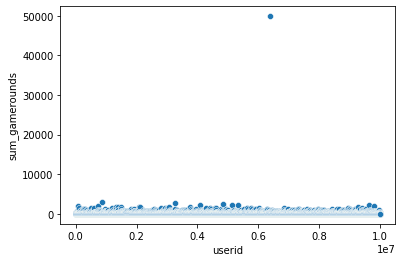

In [7]:
# Number of rounds played by users in 14 days
ax = sns.scatterplot(x='userid',y='sum_gamerounds',data=df[['userid', 'sum_gamerounds']])

Number of game rounds by user '6390605' seems like an **outlier**. In real life I'd better consult with the stakeholders, but for now I'll exclude this row.

In [5]:
# Removing a row with an outlier - user '6390605'
df = df.copy().drop(df[df.userid==6390605].index)
df.shape
# Now we have one line less in our dataframe.

(90188, 5)

#### Fix the misleading variable labels 

In [6]:
# I'll rename column 'version' and it's values to make them more comfortable to work with
df.rename(columns={'version':'group'}, inplace=True)
df['group'] = df['group'].replace({'gate_30':'A', 'gate_40':'B'})
df.head()

,userid,group,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


* ***Group A*** - gate at level 30. 
* ***Group B*** - gate at level 40.

#### Remove zeros

I've noticed some 0 values in game rounds column.

In [80]:
# How many users from the dataset didn't play any game
df.query("sum_gamerounds==0").userid.count()
# It means that 3994 users just installed the game and didn't play any round.

3994

In [79]:
df.query("sum_gamerounds==0").groupby('group', as_index=False).agg({'userid':'count'})

,group,userid
0,A,1937
1,B,2057


I assume, these users (values) won't make any impact on our experiment. So, I'll remove them from the dataset.

In [7]:
# Remove zeros from the dataframe
df = df.copy().drop(df[df.sum_gamerounds==0].index)
df.shape

(86194, 5)

#### Do we have any duplicates?

In [9]:
# Let's check the user id column for duplicates
df.duplicated().any()
# No duplicates. Ok.

False

### Continue exploring the dataset

In [9]:
df.head()

,userid,group,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


#### Total game rounds by each group

Let's check the number of game rounds by players in both groups (gate_30 and gate_40).

In [86]:
df.groupby(['group'], as_index=False).agg({'sum_gamerounds':'sum'})

,group,sum_gamerounds
0,A,2294941
1,B,2333530


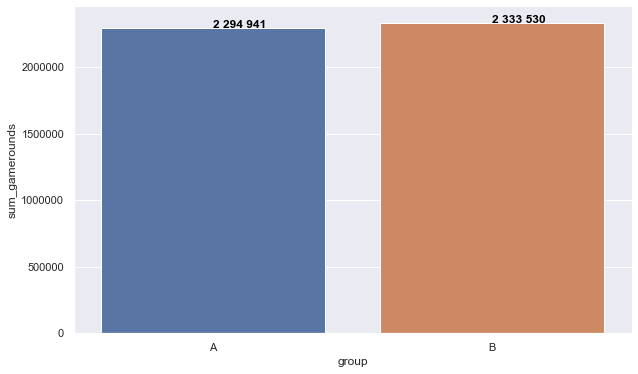

In [113]:
# Total game rounds by each group
sns.set(rc={'figure.figsize':(10, 6)})
ax = sns.barplot(x='group', y='sum_gamerounds',
            data=df.groupby(['group'], as_index=False).agg({'sum_gamerounds':'sum'}))

plt.text(0, 2294941, "2 294 941", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(1, 2333530, "2 333 530", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.despine()

In [125]:
print("Difference between group B and group A players games:", 
round(100*(df.query("group=='B'").sum_gamerounds.sum() - df.query("group=='A'").sum_gamerounds.sum()) 
      / df.query("group=='A'").sum_gamerounds.sum(), 
      2), "%"
     )

Difference between group B and group A players games: 1.68 %


As we can see, total amount of players' game rounds for 14 days **slightly increased** (1.68 %) after changing the first gate in the game from level 30 to level 40. 
But that's only 14 days. Maybe, after 30 days this change might be bigger. 

#### Average number of games by user in each group

Also, we should check if the bigger number of played rounds in group B is due to a higher number of users in that group comparing with group A.  
Let's **normalize** total amount of players' game rounds for total amount of users in each group.

In [104]:
games_A = df.query("group=='A'").sum_gamerounds.sum() # total rounds by users in group A (2294941)
games_B = df.query("group=='B'").sum_gamerounds.sum() # total rounds by users in group B (2333530)
users_A = df.query("group=='A'").userid.count()       # total users in group A (42762)
users_B = df.query("group=='B'").userid.count()       # total users in group B (43432)

In [105]:
A_games_users_ratio = games_A / users_A 
B_games_users_ratio = games_B / users_B 
print("Average number of played rounds by user in group A:", round(A_games_users_ratio, 5))
print("Average number of played rounds by user in group B:", round(B_games_users_ratio, 5))

Average number of played rounds by user in group A: 53.66777
Average number of played rounds by user in group B: 53.72836


We can see a **super small increase** in average rounds played by user in group B comparing with group A.

#### More info about retention

In [21]:
# How many users came back to play 1 day after installing? How many users in total? (Divided by groups)
pd.crosstab(df['group'], df['retention_1'], margins=True)

retention_1,False,True,All
group,,,
A,22769,19993,42762
B,23359,20073,43432
All,46128,40066,86194


In [22]:
# How many users came back to play 7 days after installing? How many users in total? (Divided by groups)
pd.crosstab(df['group'], df['retention_7'], margins=True)

retention_7,False,True,All
group,,,
A,34277,8485,42762
B,35166,8266,43432
All,69443,16751,86194


In [49]:
# Summary table
# Retention rate 1 and 7; and total num of users in each group
A_B_summary = df.groupby('group', as_index=False).agg({'retention_1':'mean', 'retention_7':'mean', 'userid':'count'})\
  .rename(columns={'retention_1':'retention_rate_1', 'retention_7':'retention_rate_7', 'userid':'num_of_users'})

# Retention by group
retention_by_group = df.groupby('group',as_index=False).agg({'retention_1':'sum', 'retention_7':'sum'})

# Add additional columns to the summary table
A_B_summary['retention_1'] = retention_by_group['retention_1']
A_B_summary['retention_7'] = retention_by_group['retention_7']
A_B_summary = A_B_summary[['group', 'retention_1', 'retention_rate_1', 'retention_7', 'retention_rate_7', 'num_of_users']]
print('Summary table:')
A_B_summary

Summary table:


,group,retention_1,retention_rate_1,retention_7,retention_rate_7,num_of_users
0,A,19993.0,0.467541,8485.0,0.198424,42762
1,B,20073.0,0.462171,8266.0,0.190321,43432


* For 1-day after the game installation we can see a **slight decrease** of retention rate in group B comparing to group A (**46.22%** vs. **46.75%**). That's the change about **1.15%**.
* For 7-day after the game installation we also can see a **slight decrease** of retention rate in group B comparing to group A (**19.03%** vs. **19.84%**). Though, that's the change almost equal to **4%** and this may have an impact on the company business performance.
* Also, we can see that total amount of users in group B is higher than in group A.

In [41]:
# Change in 7-day retention rate in %:
100 - 100*19.03/19.84

4.0826612903225765

In [43]:
# Change in 1-day retention rate in %:
100 - 100*46.217/46.754

1.1485648286777632

## 5. A/B testing

### User retention

#### Choosing statistical method

In [18]:
df

,userid,group,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True
...,...,...,...,...,...
90184,9999441,B,97,True,False
90185,9999479,B,30,False,False
90186,9999710,A,28,True,False
90187,9999768,B,51,True,False


In [20]:
df.dtypes

userid             int64
group             object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

* We can see that we have **qualitative binomial** (True-False) data in columns retention_1 and retention_7.  
* Also, we have **2 groups** (A - gate_30; B - gate_40) of users. 
* Let's say these groups are **independent** (the split of users was done right).  
* Also, we can build the contingency tables with observed frequencies of True and False by each group.

In [57]:
# Contingency table with observed frequencies for retention_1
cont_t_1 = pd.crosstab(df['group'], df['retention_1'])
cont_t_1

retention_1,False,True
group,,
A,22769,19993
B,23359,20073


In [52]:
# Contingency table with observed frequencies for retention_7
cont_t_7 = pd.crosstab(df['group'], df['retention_7'])
cont_t_7

retention_7,False,True
group,,
A,34277,8485
B,35166,8266


So, the best statistical method for the given conditions is the **chi-squared method**.

#### Formulating a hypothesis

We want to check if changing the gate from level 30 to level 40 affects users' retention. So:
* **Null hypothesis**: the two groups have no significant difference. (H0: ret_A = ret_B)
* **Alternative hypothesis**: the two groups have a significant difference. (H_alt: ret_A != ret_B)

I'll use [*chi2_contingency*](https://docs.scipy.org/doc//scipy-1.2.1/reference/generated/scipy.stats.chi2_contingency.html) function from *scipy.stats* package.  
We can use *chi2_contingency* when we don't know the underlying distribution, but we want to test whether two (or more) groups have the same distribution.  
This test just tells us if the relationship between variables is significant (i.e. may represent the population) or came by chance.

In [53]:
import scipy as sp
import scipy.stats

#### 1. Does changing the start gate from level 30 to level 40 have an impact on 1-day user retention?

In [58]:
# Function to get a dataframe from array
def expected(ar):
    return pd.DataFrame(ar, columns=['exp_False', 'exp_True'], index=['A', 'B'])

In [59]:
# Calculate chi-square, p-value, degrees of freedom and expected frequencies
chi2, p, dof, exp = sp.stats.chi2_contingency(cont_t_1)

In [60]:
expected(exp)

,exp_False,exp_True
A,22884.719772,19877.280228
B,23243.280228,20188.719772


In [61]:
# Chi-square and p-value
print('Chi2 =', chi2)
print('P-value =', p)

Chi2 = 2.47671866669166
P-value = 0.11554308221600512


For 2 x 2 tables and **5% significance level** the critical value of **chi2_crit = 3.841**.  
For **1% significance level** - **chi2_crit = 6.635**.  
For **10% significance level** - **chi2_crit = 2.706**.

In [68]:
# A function to output the result of testing
ret=1
def output(p):
    if p < 0.1 and p > 0.05:
        print("Reject H0. \nThere is a statistically significant difference in users' {}-day retention from changing the start gate from level 30 to level 40 with 10% level of significance.".format(ret))
    elif p < 0.05 and p > 0.01:
        print("Reject H0. \nThere is a statistically significant difference in users' {}-day retention from changing the start gate from level 30 to level 40 with 5% level of significance.".format(ret))
    elif p < 0.01:
        print("Reject H0. \nThere is a statistically significant difference in users' {}-day retention from changing the start gate from level 30 to level 40 with 1% level of significance.".format(ret))
    else:
        print("Reject H_alt. There is no statistically significant difference between two groups.")

In [63]:
# Result of chi2 A/B test for 1-day retention
output(p)

Reject H_alt. There is no statistically significant difference between two groups.


So, we can state that ***changing the start gate*** of the game from level 30 to level 40 ***doesn't affect*** on 1-day user's retention.

#### 2. Does changing the start gate from level 30 to level 40 have an impact on 7-day user retention?

In [69]:
# Calculate chi-square, p-value, degrees of freedom and expected frequencies 
chi2, p, dof, exp = sp.stats.chi2_contingency(cont_t_7)

In [70]:
expected(exp)

,exp_False,exp_True
A,34451.604126,8310.395874
B,34991.395874,8440.604126


In [71]:
# Chi-square and p-value
print('Chi2 =', chi2)
print('P-value =', p)

Chi2 = 8.984877907964687
P-value = 0.0027222297777463066


In [72]:
# Result of chi2 A/B test for 7-day retention
ret=7
output(p)

Reject H0. 
There is a statistically significant difference in users' 7-day retention from changing the start gate from level 30 to level 40 with 1% level of significance.


Here, we can state that ***changing the start gate*** of the game from level 30 to level 40 actually ***have an impact*** on 7-day user's retention with 1% level of significance (99% of cases).  

Also, we can check our finding on [A/B-Test Calculator](https://abtestguide.com/calc/):

In [83]:
from IPython.display import Image, display

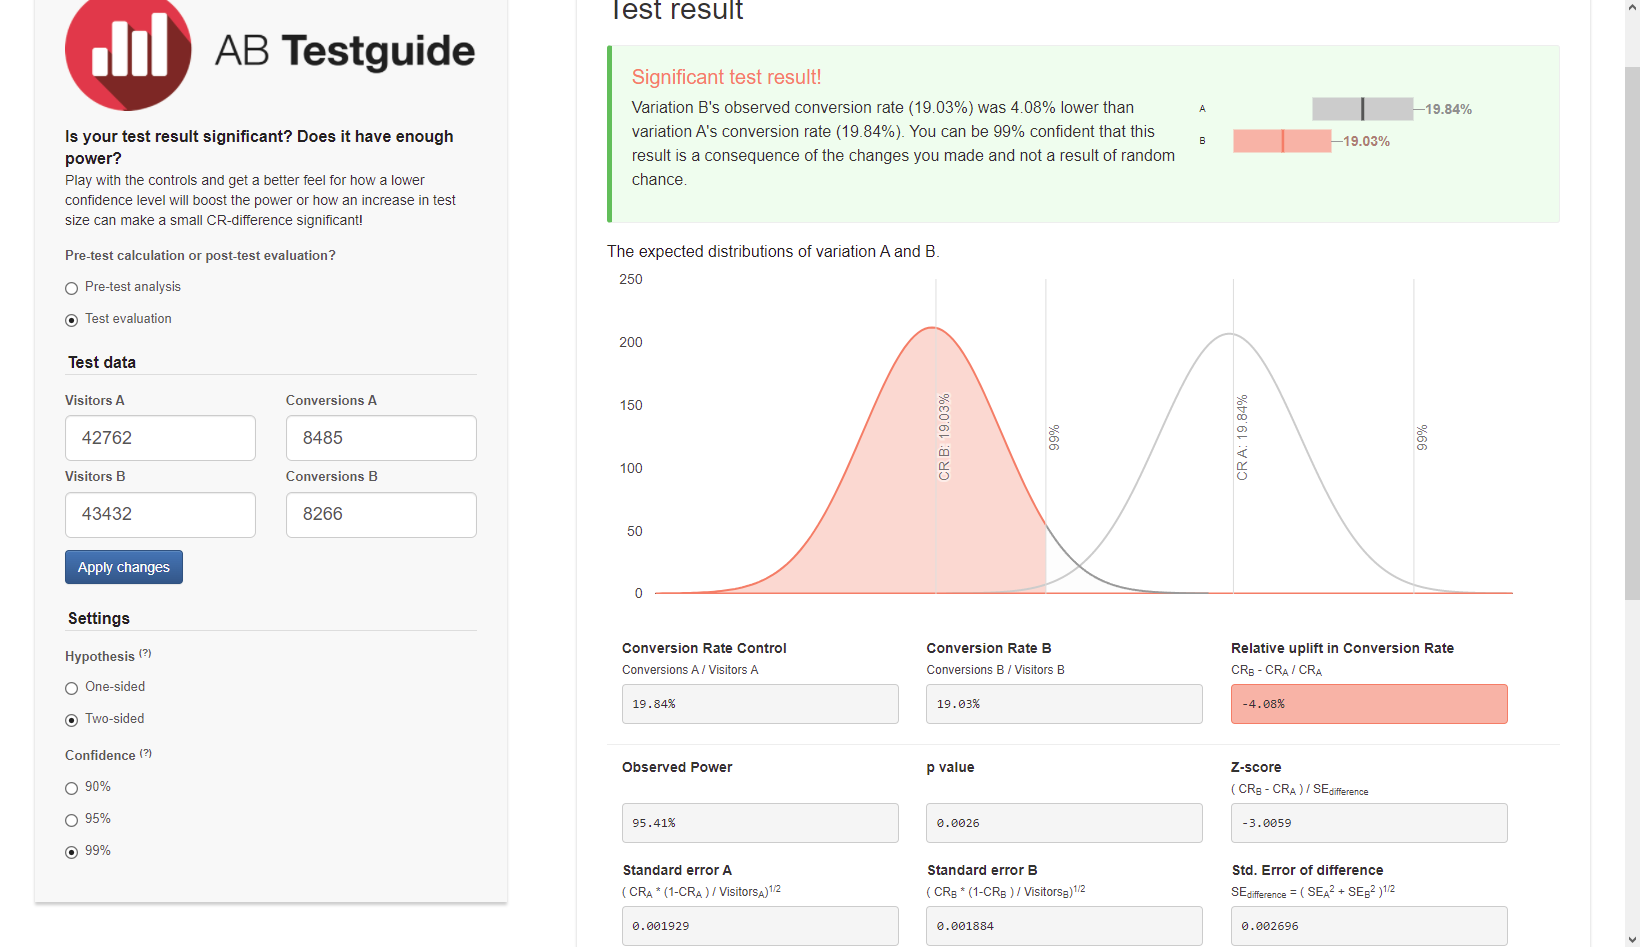

In [90]:
Image(filename='abtestguide.com_retention_7.png') 

We see the **confirmation** of our A/B test result.

#### Recommendation
In view of the above and the fact that user's retention at gate 30 is a little bit bigger than one at gate 40, I'd **not recommend** to change the start gate from level 30 to level 40, because this may decrease players' retention, which can lead to a negative effect on business performance in the future.

### Number of game rounds

#### Choosing statistical method

We'll do an A/B test to see if there is a statistically significant difference in game rounds between group A (gate_30) and group B (gate_40).  

* Sum_gamerounds is **quantitative data**.

Is sum_gamerounds distributed normally?

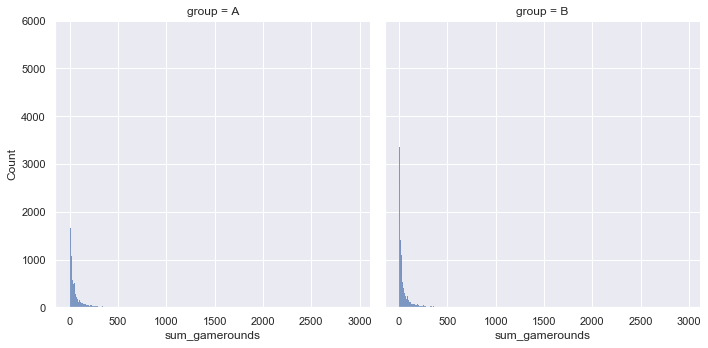

In [43]:
# Distribution of sum_gamerounds
sns.set(rc={'figure.figsize':(10, 6)})
ax = sns.displot(df, x="sum_gamerounds", col="group")
ax.set(ylim=(0, 6000))
sns.despine()

* As we can see, sum_gamerounds **is not** distributed normally.
* We'll compare **2** groups.
* Also, let's assume our groups are **independent** (the split of users was done right).

So, the best statistical method for the given conditions is the **Mann-Whitney U test**.

#### Formulating a hypothesis

We want to see if there is a statistically significant difference in played game rounds by users in group A (gate_30) and group B (gate_40). So:
* **Null hypothesis**: changing the start gate level has **no impact** on sum_gamerounds. (H0: sum_gamerounds_A = sum_gamerounds_B)
* **Alternative hypothesis**: changing the start gate level **has** an impact on sum_gamerounds. (H_alt: sum_gamerounds_A != sum_gamerounds_B)

I'll use [*mannwhitneyu*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) function from *scipy.stats* package.  
We can use *mannwhitneyu* to compare the differences between two independent samples when the sample distributions are not normally distributed len(B_rounds) and the sample sizes are small (n <30). It is considered to be the nonparametric equivalent to the two-sample independent t-test.

#### Mann-Whitney U test 

First, we need to get two arrays of sum_gamerounds values for group a and group B.

In [98]:
import numpy as np

In [99]:
A_rounds = df.query("group=='A'").sum_gamerounds.to_numpy() # array of game rounds in group A
B_rounds = df.query("group=='B'").sum_gamerounds.to_numpy() # array of game rounds in group B

In [49]:
# Calculate statistic and p-value
res = sp.stats.mannwhitneyu(A_rounds, B_rounds)
print(res)

MannwhitneyuResult(statistic=922907061.0, pvalue=0.05883357300380917)


Let's check the power of the test.

In [12]:
from statsmodels.stats.power import tt_ind_solve_power

In [53]:
# effect_size - difference between the two means divided by the standard deviation
A_rounds_mean = np.mean(A_rounds)
B_rounds_mean = np.mean(B_rounds)
sd_A = np.std(A_rounds)
sd_B = np.std(B_rounds)
se = np.sqrt((np.square(sd_A)/len(A_rounds)) + (np.square(sd_B)/len(B_rounds)))
effect_size = (B_rounds_mean - A_rounds_mean) / se
effect_size

0.08518162030526692

In [55]:
len(B_rounds)/len(A_rounds)

1.015668116552079

In [57]:
# power of the test
tt_ind_solve_power(effect_size= 0.085, nobs1 = len(B_rounds), alpha=0.05, power=None, ratio=1.016, alternative='two-sided')

1.0

Let's try to implement a condition about small sample sizes in Mann-Whitney tests and get 25 random values from each group.

In [59]:
import random

In [65]:
A_rounds_random = random.choices(A_rounds, k=25)
B_rounds_random = random.choices(B_rounds, k=25)

In [66]:
# Calculate statistic and p-value
res = sp.stats.mannwhitneyu(A_rounds_random, B_rounds_random)
print(res)

MannwhitneyuResult(statistic=308.0, pvalue=0.4690426136046061)


In [69]:
# effect_size - difference between the two means divided by the standard deviation
A_rounds_rand_mean = np.mean(A_rounds_random)
B_rounds_rand_mean = np.mean(B_rounds_random)
sd_A_rand = np.std(A_rounds_random)
sd_B_rand = np.std(B_rounds_random)
se_rand = np.sqrt((np.square(sd_A_rand)/len(A_rounds_random)) + (np.square(sd_B_rand)/len(B_rounds_random)))
effect_size_rand = (A_rounds_rand_mean - B_rounds_rand_mean) / se_rand
effect_size_rand

0.4553147954178361

In [70]:
# power of the test
tt_ind_solve_power(effect_size= effect_size_rand, nobs1 = 25, alpha=0.05, power=None, ratio=1, alternative='two-sided')

0.3512976835808078

**But** our given sample sizes are too big for Mann-Whitney test (n>>30) and the statistical power of such test would be very poor.  
So, let's try a **Student's t test**.  

(At the same time, we note that, according to Mann-Whitney test, we got p-values > 0.05 both times. So, we should fail to reject the Null hypothesis (H0: sum_gamerounds_A = sum_gamerounds_B)).

#### Student t test 

##### 1. Is there an increase in sum_gamerounds after changing the start gate level?

Again:
* **Null hypothesis**: No statistically significant differences between groups. Changing the start gate level has **no impact** on sum_gamerounds. (H0: sum_gamerounds_A = sum_gamerounds_B)
* **Alternative hypothesis**: There is statistically significant differences between groups. Changing the start gate level **has** a positive impact on sum_gamerounds (increase it). (H_alt: sum_gamerounds_A **<** sum_gamerounds_B)

I'll use [*ttest_ind*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy-stats-ttest-ind) function from *scipy.stats* package.  

In [24]:
# Calculating t and p-value
res = sp.stats.ttest_ind(A_rounds, B_rounds, equal_var=False, alternative='less')
t, p = sp.stats.ttest_ind(A_rounds, B_rounds, equal_var=False, alternative='less')
# equal_var=False - for Welch’s t-test, which does not assume equal population variance
# alternative='less' - the mean of the group A distribution is less than the mean of the group B distribution
print(res)

Ttest_indResult(statistic=-0.08518063202473634, pvalue=0.46605899293000597)


In [26]:
output(p)

Reject H_alt. There is no statistically significant difference between two groups.


##### 2.  Is there a difference in sum_gamerounds after changing the start gate level?

Maybe, we should check if there are basically differences between groups:
* **Null hypothesis**: No statistically significant differences between groups. (H0: sum_gamerounds_A = sum_gamerounds_B)
* **Alternative hypothesis**: There is statistically significant differences between groups. (H_alt: sum_gamerounds_A **<** sum_gamerounds_B)

In [28]:
# Calculating t and p-value
res = sp.stats.ttest_ind(A_rounds, B_rounds, equal_var=False, alternative='two-sided')
t, p = sp.stats.ttest_ind(A_rounds, B_rounds, equal_var=False, alternative='two-sided')
print(res)

Ttest_indResult(statistic=-0.08518063202473634, pvalue=0.9321179858600119)


In [30]:
output(p)

Reject H_alt. There is no statistically significant difference between two groups.


By results of the t-test, we can state that ***changing the start gate*** of the game from level 30 to level 40 actually ***doesn't have an impact*** on game rounds played by users during the first 14 days after install.  

## 6. Recommendations

#### Total played game rounds

In [109]:
print('Total game rounds with gate_30:', A_rounds.sum(), '| Average number of played rounds by users with gate_30:', round(A_games_users_ratio, 5))
print('Total game rounds with gate_40:', B_rounds.sum(), '| Average number of played rounds by users with gate_40:', round(B_games_users_ratio, 5))

Total game rounds with gate_30: 2294941 | Average number of played rounds by users with gate_30: 53.66777
Total game rounds with gate_40: 2333530 | Average number of played rounds by users with gate_40: 53.72836


We detected that total game rounds in group B is a little bit bigger than game rounds in group A. But the A/B t-test results showed that there is statistically significant difference between two groups.  
So, we can state that ***changing the start gate*** of the game from level 30 to level 40 actually ***doesn't have an impact*** on game rounds played by users during the first 14 days after install.

#### User retention

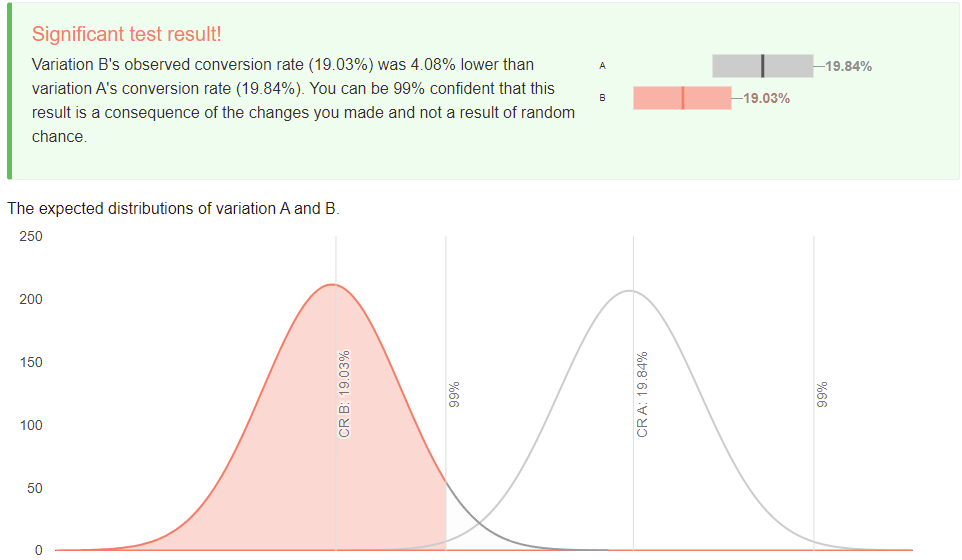

In [95]:
Image(filename='abtestguide.com_retention_7_distplot.png') 

We conducted a *chi-square A/B test* on user's retention and could get a probabilistic assessment that **there is a statistically significant** difference between two groups.  
So, we can state that changing the start gate of the game from level 30 to level 40 actually have an impact on 7-day user's retention with 1% level of significance (**99% confidence**).

Since user's retention at gate 30 is a little bit bigger than one at gate 40, I'd ***not recommend to change the start gate from level 30 to level 40***, because this may decrease players' retention, which can lead to a negative effect on business performance in the future.

#### Next steps

Anyway, we should do some further research, e.g. calculate how much users in both groups spend on in-game purchases or amount of viewed ads or check users' retention by daily cohorts.

**THANK YOU!**